In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import curve_fit # we're importing just this one function from scipy.optimize
from scipy.interpolate import UnivariateSpline

3581918.0
122.0703125


list

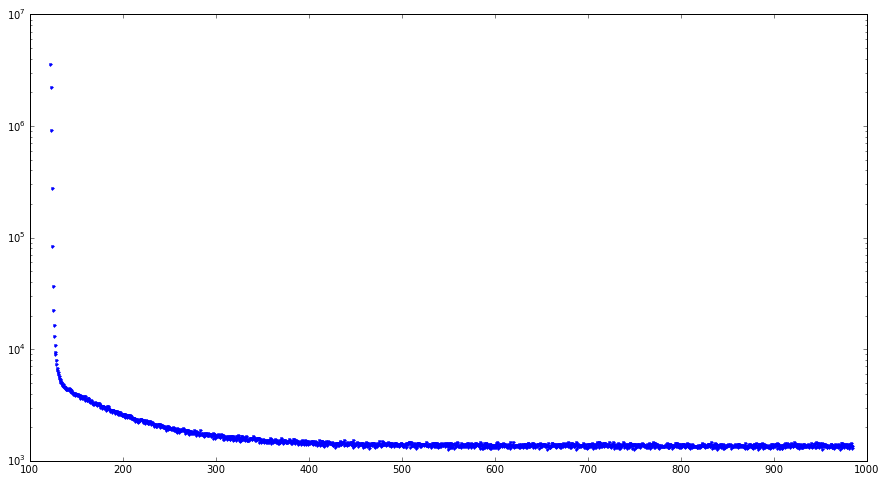

In [24]:
plt.figure(num=None, figsize=(15, 8), dpi=80, facecolor='w', edgecolor='k')

ydata = np.loadtxt('N:/Lab 3/Positronium/161014_lifetime_23-24psi_delay_115(2.5)ns.csv', comments = '#', unpack = True)
xdata = 1000*np.arange(0,2048) / 2048.0

index = [item for item in range(len(ydata)) if ydata[item] == 0]
ydata = [i for j, i in enumerate(ydata) if j not in index]
xdata = [i for j, i in enumerate(xdata) if j not in index]

print(np.max(ydata))

x_index = np.arange(len(xdata))


for i in x_index:
    if ydata[i] == np.max(ydata):
        start = i
        x0 = xdata[start]
print(x0)

xdata_cut = xdata[start:]
ydata_cut = ydata[start:]


plt.semilogy(xdata_cut,ydata_cut,'b.')

type(ydata)


In [32]:
import scipy as sp
from numpy.polynomial.legendre import legint
from scipy.linalg import lu_factor, lu_solve

def intMatLegendre(n,order):    
    """ Legendre polynomial integration matrix """

    I = np.eye(n)
    B = legint(I,order)

    return B

class ode_solver(object):

    def __init__(self,m,p):

        self.m = m
        self.p = p
        self.B = []
        self.a = np.zeros(p)
        self.c = np.zeros(p)
        self.y = np.zeros(m)

        for k in range(p):
            self.B.insert(0,intMatLegendre(m,p-k)[p:(k-p),:])

        self.B.insert(0,intMatLegendre(m,0)[p:,:])

    def setCoeffs(self,a):
        """ Construct the solution operator given the coefficients
            do the LU decomposition
        """

        # Update system matrix only if coefficients change
        if self.a is not a:

            self.a = a
            A = np.zeros((self.m-self.p,self.m))

            for k in range(self.p+1):
                A += self.a[k]*self.B[self.p-k]         
            # L,U,P factors for the system matrix
            self.factors = lu_factor(A[:,self.p:])

            # Moment condition terms
            self.cond = A[:,:self.p]

    def solve(self,c,f):
        self.c = c
        self.y[:self.p] = c
        rhs = np.dot(self.B[-1],f) - np.dot(self.cond,c)
        self.y[self.p:] = lu_solve(self.factors,rhs)
        return self.y.copy()

    def tangent(self):
        dy = np.zeros((self.m,self.p+1))

        for k in range(self.p+1):
            By = np.dot(self.B[self.p-k],self.y)
            dy[self.p:,k] = -lu_solve(self.factors,By)


        return dy         
    

from numpy.polynomial.legendre import legval, legvander
from scipy.optimize import leastsq

class expfit(object):
    
    def __init__(self,t,m,p):
        """ 
        t - original grid (possibly nonuninform)
        m - number of polynomial modes
        p - order of differential equation
        
        """ 
        
        self.n = len(t)
        dt = t[1:]-t[:-1]

        self.m = m;  self.p = p       
        self.scale = 2/(t[-1]-t[0])

        # Trapezoidal weights
        self.w       = np.zeros(self.n)
        self.w[0]    = 0.5*dt[0]
        self.w[1:-1] = 0.5*(dt[1:]+dt[:-1])
        self.w[-1]   = 0.5*dt[-1]
        self.w      *= self.scale 
        
        # Mapped absiccae
        self.t = t
        self.x = 2*(t-t[0])/(t[-1]-t[0])-1
        self.L = legvander(self.x,p-1)

        self.solver = ode_solver(m,p)
        self.yhat = np.zeros(m) 

    def setTarget(self,z):
        self.z = z

    def setCoeffs(self,a):
        self.solver.setCoeffs(a)

    def computeState(self,z,fhat):
        """ Update state """
        c = np.dot(self.L.T,self.w*z)*(0.5+np.arange(self.p))         
        self.yhat = self.solver.solve(c,fhat)
        return self.yhat.copy()

    def getResidual(self,a):
        """ Computes difference between data and model """
        self.solver.setCoeffs(a)
        c = np.dot(self.L.T,self.w*self.z)*(0.5+np.arange(self.p))         
        self.yhat = self.solver.solve(c,np.eye(self.m)[0])
        y = legval(self.x,self.yhat)
        res = self.z-y
        return res        

    def getJacobian(self,a):
        """ Computes the Jacobian of the residual """
        self.solver.setCoeffs(a)
        J = np.zeros((self.n,self.p+1))

        dy = self.solver.tangent()
        for k in range(self.p+1):
            J[:,k] = -legval(self.x,dy[:,k])

        return J


    def getOptCoeffs(self,z,a0):
        """ Compute the optimal exponential and mantissa coefficients
            so that the model best matches the data. 

            a0 is an initial guess  """

        self.setTarget(z)
        aopt = leastsq(self.getResidual,a0,Dfun=self.getJacobian)

        # Compute the roots (exponential decay rates)
        lam = np.roots(np.flipud(aopt[0]))*self.scale
        V = np.exp(np.outer(self.t,np.hstack((0,lam))))
        lsq = np.linalg.lstsq(V,z)
        alp = lsq[0][0]
        bet = lsq[0][1:]
        
        return alp,bet,lam,aopt[0]

    def getCurrentState(self):
        return legval(self.x,self.yhat)

In [40]:
type(xdata_cut)
xdata_cut = np.array(xdata_cut)
print(xdata_cut)

ydata_cut = np.array(ydata_cut)
print(ydata_cut)


[ 122.0703  122.5586  123.0469 ...,  982.9102  983.3984  983.8867]
[  3.5819e+06   2.2546e+06   9.2055e+05 ...,   1.3790e+03   1.3440e+03   1.3110e+03]


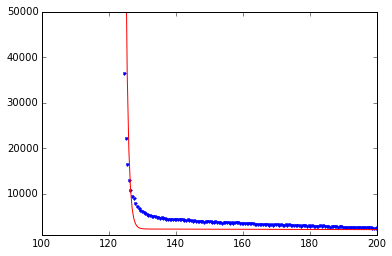

-34483.3211183
[     0.      62777.0062]
[ -1.3732e+00  -8.4361e-04]


In [49]:
if __name__ == '__main__':

    n = 30000    # Number of time steps
    m = 200      # Number of polynomial modes
    p = 2       # Number of exponentials 
    
    #t = np.linspace(100,1000,n)
 
    np.set_printoptions(precision=4,linewidth=999)


    fit = expfit(xdata_cut,m,p)

    a0 = np.ones(p+1)

    alp,bet,lam,aopt = fit.getOptCoeffs(ydata_cut,a0)
    y = fit.getCurrentState()

    plt.plot(xdata_cut,ydata_cut,'b.',xdata_cut,y,'r-')
    plt.xlim(100, 200)
    plt.ylim(1000, 50000)
    plt.show() 

    print alp
    print bet
    print lam